In [1]:
from LensCalcPy.survey import *
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from tqdm import tqdm
from pathos.multiprocessing import ProcessingPool as Pool
import functools
from scipy.integrate import nquad
import pandas as pd

%load_ext autoreload
%autoreload 2

In [2]:
# HSC Params
# l = 121.2
# b = -21.6
# ds = 770
# obsTime = 7
# survey_area = 0
# n_sources = 8.7e7
# efficiency = 0.5
from LensCalcPy.parameters import *

In [3]:
s = Survey(l, b, ds, obs_time, survey_area=survey_area, n_sources=n_sources, cadence=0.035, efficiency=0.7)
s

Survey(l=121.2, b=-21.6, source_dist=770, obs_time=7, cadence = 0.035, survey_area=1.767144375, n_sources=87000000.0, efficiency=0.7)

In [4]:
t_es = np.logspace(-2, 1, 20) #hours

In [5]:
m = 1e-8
s.add_pbh(m)
diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False)

/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


/Users/nolansmyth/opt/anaconda3/lib/python3.9/site-packages/scipy/integrate/quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


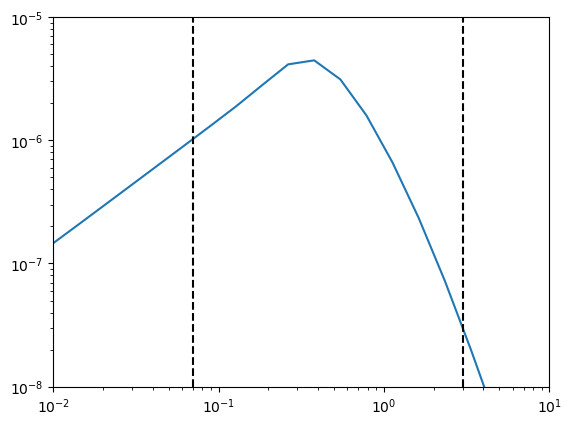

In [6]:
plt.loglog(t_es, diff_rates)
plt.axvline(0.07, color='k', ls='--')
plt.axvline(3, color='k', ls='--')
plt.xlim(1e-2, 1e1)
plt.ylim(1e-8,1e-5)
plt.show()

In [5]:
def get_n_events_point(m):
    ti = 0.07
    tf = 3
    s.add_pbh(m)
    diff_rates = s.get_crossing_times_rates_pbh(t_es, finite=False)
    rate_interp = interp1d(t_es, diff_rates)
    dnds = quad(rate_interp, ti, tf)[0]
    return s.n_sources*dnds*s.obs_time*s.efficiency

def get_n_events_finite(m):
    s.add_pbh(m)
    dnds = s.pbh.rate_tot(finite=True)
    return s.n_sources*dnds*s.obs_time

def get_constraint_fdm(m, finite=False):
    if finite:
        n_events = get_n_events_finite(m)
    else:
        n_events = get_n_events_point(m)
    if n_events != 0:
        return 4.74/n_events
    else:
        return 1
    
def get_constraint_fdm_parallel(m_pbhs, finite=False):
    with Pool() as p:
        f = functools.partial(get_constraint_fdm, finite=finite)
        results = list(tqdm(p.imap(f, m_pbhs), total=len(m_pbhs)))

    return results

In [6]:
m_pbhs = np.logspace(-15, -4, 25) #solar masses
fdms = get_constraint_fdm_parallel(m_pbhs, finite=False)

100%|██████████| 25/25 [01:07<00:00,  2.69s/it]


In [7]:
fdm_finite = get_constraint_fdm_parallel(m_pbhs, finite=True)

100%|██████████| 25/25 [00:13<00:00,  1.86it/s]


In [8]:
# Define conversion factor
sol_to_gram = 1.989e33
m_grams = [x*sol_to_gram for x in m_pbhs]

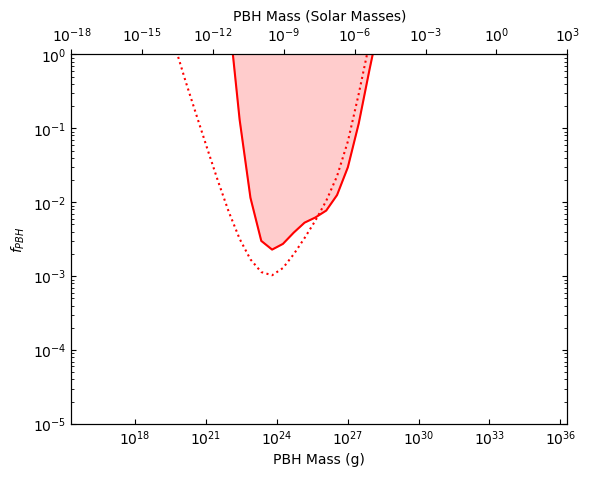

In [9]:
# Define conversion factor
sol_to_gram = 1.989e33

fig, ax2 = plt.subplots()

# Plot on first x-axis
ax2.plot(m_grams, fdms, 'r', ls=':')
ax2.plot(m_grams, fdm_finite, 'r', ls='-')
ax2.fill_betweenx(fdm_finite, m_grams, color='r', alpha=0.2)  # shade the area above the curve
# ax2.fill_betweenx(fdms, [x*sol_to_gram for x in m_pbhs], color='r', alpha=0.2)  # shade the area above the curve

ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('PBH Mass (g)')
ax2.set_ylabel(r'$f_{PBH}$')
ax2.set_ylim(1e-5, 1e0)
ax2.set_xlim([x*sol_to_gram for x in [1e-18, 1e3]])

ax2.tick_params(axis='both', which='both', direction='in', top=True, right=True)

ax1 = ax2.twiny()  # create a second x-axis

# Set the limits of the second x-axis
ax1.set_xlim(1e-18, 1e3)
ax1.set_xscale('log')
ax1.set_xlabel('PBH Mass (Solar Masses)')

plt.show()